In [1]:
#RNN, usually for Image Captioning, time series prediction, nlp
#import lib

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
ds=pd.read_csv('Milk.csv',index_col='Month') 
print(ds)

         MilkProduction
Month                  
1962-01             589
1962-02             561
1962-03             640
1962-04             656
1962-05             727
...                 ...
1975-08             858
1975-09             817
1975-10             827
1975-11             797
1975-12             843

[168 rows x 1 columns]


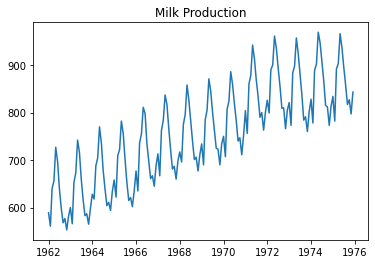

In [3]:
ds.index=pd.to_datetime(ds.index) #obj to date64

plt.title("Milk Production")
plt.plot(ds)
plt.show()

In [4]:
#split train test
testing_size=int(len(ds)/8)
training = ds.head(len(ds)-testing_size)
testing=ds.tail(testing_size)

In [5]:
#normalize
mms=MinMaxScaler()
training_ds=mms.fit_transform(training)
testing_ds=mms.fit_transform(testing)

In [6]:
#initialize var
input_layer=1
output_layer=1
context_layer=90 #hidden
time_step = 20 #3rd dimension of 3d tensor
batch_size=2 #number of sample processed before the model updated
epoch=3000 #number of complete training ds
learning_rate=0.02

In [7]:
#BasicRNNCell architecture
#many more: GRUCell,BasicLSTMCell, LSTMCell,BasicRNNCell,MultiRNNCell,DropoutWrapper

cell=tf.nn.rnn_cell.BasicRNNCell(context_layer,activation=tf.nn.relu)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [8]:
#connect context to ouput
cell=tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=output_layer,activation=tf.nn.relu)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
#Placeholder
input_placeholder = tf.placeholder(tf.float32,[None,time_step,input_layer])
output_placeholder = tf.placeholder(tf.float32,[None,time_step,output_layer])

In [10]:
#Connect input placeholder to RNN
output,state = tf.nn.dynamic_rnn(cell,input_placeholder,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
#Error (MSE)
error = tf.reduce_mean(0.5*(output_placeholder-output)**2)

In [12]:
#optimizer
train=tf.train.AdamOptimizer(learning_rate).minimize(error)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
#training batch method
def batch(ds,time_step,batch_size):
    x_batch = np.zeros(shape=(batch_size, time_step, input_layer)) #set value to 0
    y_batch = np.zeros(shape=(batch_size, time_step, output_layer))
    
    #define [start:end]
    for i in range(batch_size):
        random=np.random.randint(0, len(ds)-time_step)
        x_batch[i]=ds[random: random+time_step]
        y_batch[i]=ds[random+1:random+time_step+1]
        
    return x_batch,y_batch    

In [14]:
#Training

saver=tf.train.Saver() #create obj to save training data/model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoch):
        
        #train ds
        x_batch, y_batch = batch(training_ds,time_step,batch_size)
        sess.run(train, feed_dict={
            input_placeholder:x_batch,
            output_placeholder:y_batch
        })
        
        #print every 100
        if i % 100==0:
            print("Iteration:%d,Loss:%.2f%%"%(i, sess.run(error, feed_dict={
                input_placeholder:x_batch,
                output_placeholder:y_batch
            })*100))
            
    saver.save(sess, 'models/milk.ckpt')

Iteration:0,Loss:1211.07%
Iteration:100,Loss:0.49%
Iteration:200,Loss:0.49%
Iteration:300,Loss:0.62%
Iteration:400,Loss:0.50%
Iteration:500,Loss:0.37%
Iteration:600,Loss:0.37%
Iteration:700,Loss:0.35%
Iteration:800,Loss:0.29%
Iteration:900,Loss:0.30%
Iteration:1000,Loss:0.25%
Iteration:1100,Loss:0.25%
Iteration:1200,Loss:0.22%
Iteration:1300,Loss:0.30%
Iteration:1400,Loss:0.14%
Iteration:1500,Loss:0.14%
Iteration:1600,Loss:0.20%
Iteration:1700,Loss:0.06%
Iteration:1800,Loss:0.16%
Iteration:1900,Loss:0.11%
Iteration:2000,Loss:0.09%
Iteration:2100,Loss:0.06%
Iteration:2200,Loss:0.16%
Iteration:2300,Loss:0.11%
Iteration:2400,Loss:0.16%
Iteration:2500,Loss:0.17%
Iteration:2600,Loss:0.17%
Iteration:2700,Loss:0.08%
Iteration:2800,Loss:0.12%
Iteration:2900,Loss:0.09%


In [15]:
#Testing

with tf.Session() as sess:
    
    #restore training model
    saver.restore(sess, 'models/milk.ckpt')
    
    #convert ds to list
    testing_dataset_list = list(testing_ds)
    
    #testing dataset
    for i in range(testing_size):
        x_batch = np.array(testing_dataset_list[-time_step:]).reshape(1, time_step, input_layer)
        prediction = sess.run(output, feed_dict={input_placeholder:x_batch})
        testing_dataset_list.append(prediction[0,-1,0])
    

INFO:tensorflow:Restoring parameters from models/milk.ckpt


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


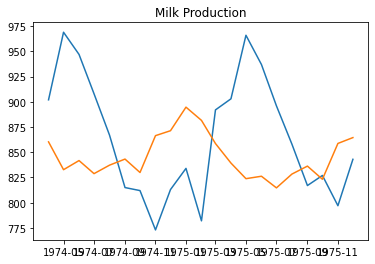

In [16]:
#re-transform testing dataset
prediction_result = mms.inverse_transform(np.array(testing_dataset_list[-testing_size:]).reshape(testing_size,1))

compare = testing.tail(testing_size)
compare['prediction']=prediction_result

plt.title('Milk Production')
plt.plot(compare) #Orange prediction
plt.show()